# TODO:

Try:

* Different models:
  * Sarsa Linear (done)
  * Sarsa ANN (done)
  * Q-learning Linear?
  * Q-learning ANN without experience replay
  * Q-learning aNN with experience replay (DQN)
* Different loss functions:
  * MSE -> leads to updates as in Sutton, Barto
  * SmoothL1?
  * What do they use in DQN paper?

In [1]:
from cart_pole import *

# Settings

In [2]:
ENVIRONMENT_ID = "CartPole-v1"
NUM_EPISODES = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch device:", device)

PyTorch device: cuda


# Sarsa

## Linear model

Average return per episode: 22.675


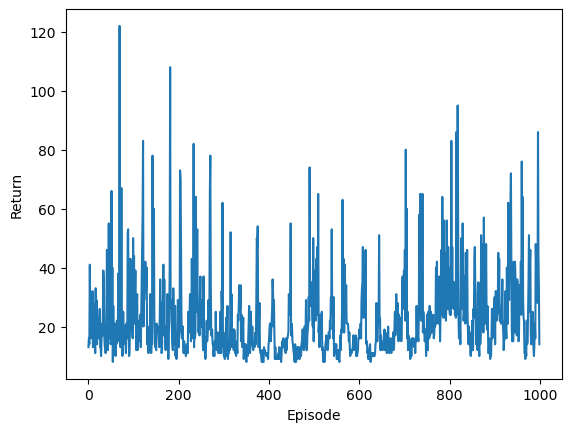

In [3]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

Average return per episode: 64.57


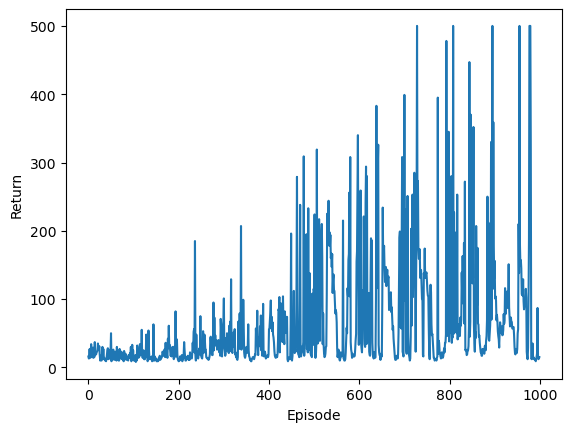

In [4]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_sarsa(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

# Q-learning

## Linear model

Average return per episode: 20.426


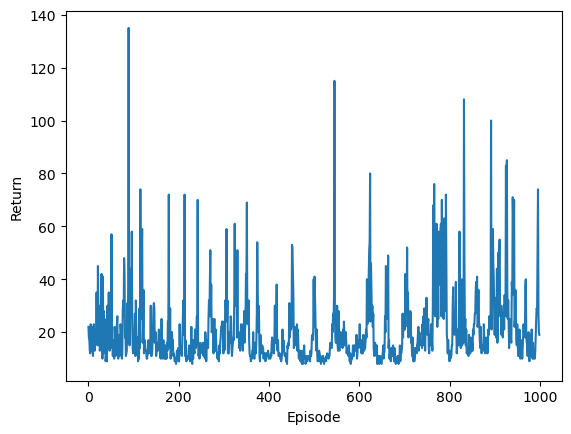

In [5]:
env = gym.make(ENVIRONMENT_ID)
model = LinearModel(env.observation_space.shape[0], env.action_space.n).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)

## Simple Neural Network

Average return per episode: 68.529


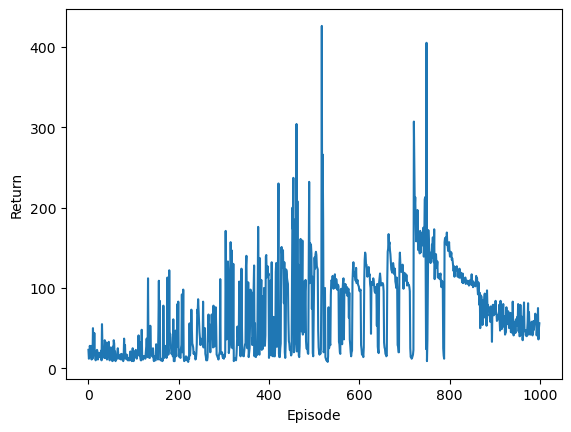

In [6]:
env = gym.make(ENVIRONMENT_ID)
model = nn.Sequential(
    nn.Linear(env.observation_space.shape[0], 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, env.action_space.n)
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, amsgrad=True)
loss_func = nn.MSELoss()
returns = train_episodic_semi_gradient_qlearning(env, model, loss_func, optimizer, device, NUM_EPISODES)
env.close()
plot_returns(returns)